In [1]:
%matplotlib inline

### Load required package

In [2]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import wasserstein_distance
from joblib import Parallel, delayed
import warnings
from statsmodels.tools.sm_exceptions import IterationLimitWarning

### Prepare for the experiments

In [3]:
m1_set=np.round(10**np.linspace(1, 2, 10)).astype(int)
n_set=m1_set**2
m2_set=m1_set*5
m3_set=m1_set*10

In [4]:
m_set=np.zeros((3,10)).astype(int)
m_set[0,:]=m1_set
m_set[1,:]=m2_set
m_set[2,:]=m3_set

In [5]:
m_set

array([[  10,   13,   17,   22,   28,   36,   46,   60,   77,  100],
       [  50,   65,   85,  110,  140,  180,  230,  300,  385,  500],
       [ 100,  130,  170,  220,  280,  360,  460,  600,  770, 1000]])

In [6]:
n_set

array([  100,   169,   289,   484,   784,  1296,  2116,  3600,  5929,
       10000])

In [7]:
d = 3 # dimensions of covariates
run=10

x1lb=0;
x1ub=10;
x2lb=-5;
x2ub=5;
x3lb=0;
x3ub=5;
# range of covariates

a0=5;
a1=1;
a2=2;
a3=0.5;
r0=1;
r1=0.1;
r2=0.2;
r3=0.05;
# example coefficients

In [8]:
def fit_model(q): # quantile regression
    warnings.filterwarnings("ignore", category=IterationLimitWarning)
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['A'],res.params['B'],res.params['C']]

def QRGMM_xstar(x,u): # QRGMM online algorithm: input specified covariates (1*(d+1)), output sample vector (k*1)
    quantile_curve=np.reshape(np.dot(nmodels[:,1:(d+2)],x.T),-1)
    quantile_curve_augmented=np.zeros(m+1)
    quantile_curve_augmented[0]=quantile_curve[0]
    quantile_curve_augmented[1:m]=quantile_curve
    quantile_curve_augmented[m]=quantile_curve[-1]
    order=u//le
    order=order.astype(np.uint64)
    alpha=u-order*le
    q1=quantile_curve_augmented[order]
    q2=quantile_curve_augmented[order+1]
    q=q1*(1-alpha/le)+q2*(alpha/le)
    return q

In [9]:
def normfun(x, mu, sigma):
    pdf = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
    return pdf
def g1fun(x_1,x_2,x_3):
    g1=a0+a1*x_1+a2*x_2+a3*x_3
    return g1 
def g2fun(x_1,x_2,x_3):
    g2=r0+r1*x_1+r2*x_2+r3*x_3
    return g2 

In [10]:
# covariates of test data, x0=(6,1,2)
x0_1=6
x0_2=1
x0_3=2 

### Run Experiments

In [11]:
############################### generate data ###############################
for runi in np.arange(0,run):
    np.random.seed(runi)
    for i in np.arange(0,10):
        n=n_set[i]
        u1=np.random.rand(n)
        x1=x1lb+(x1ub-x1lb)*u1
        u2=np.random.rand(n)
        x2=x2lb+(x2ub-x2lb)*u2
        u3=np.random.rand(n)
        x3=x3lb+(x3ub-x3lb)*u3
        g1=a0+a1*x1+a2*x2+a3*x3
        g2=r0+r1*x1+r2*x2+r3*x3
        F=np.zeros((n,4))
        for j in np.arange(0,n):
            F[j,0]=x1[j]
            F[j,1]=x2[j]
            F[j,2]=x3[j]
            F[j,3]=np.random.normal(g1[j],g2[j])
        df = pd.DataFrame(F, columns=list('A''B''C''F')) # training data
        os.makedirs("./data_QC/traindata", exist_ok=True)
        df.to_csv("./data_QC/traindata/traindata" + '_{}_run{}.csv'.format(i+1,runi+1),index=0)

### Calculate quantile crossing rate as n grows

In [12]:
def crossing_test(m, x1, x2, x3):
    u = np.linspace(1/m, 1-1/m, m-1)
    ctestx = np.zeros((1, d+1))
    ctestx[:, 0] = 1
    ctestx[:, 1] = x1
    ctestx[:, 2] = x2
    ctestx[:, 3] = x3
    return QRGMM_xstar(ctestx, u)

In [13]:
crossing_count=np.zeros((3,10,run))
crossing_rate=np.zeros((3,10,run))
for runi in np.arange(0,run):
    np.random.seed(runi)
    for i in np.arange(0,10):
        n=n_set[i] # fedelity parameter in QRGMM
        df=pd.read_csv("./data_QC/traindata/traindata" + '_{}_run{}.csv'.format(i+1,runi+1))
        for j in np.arange(0,3):
            m=m_set[j,i]
            le=1/m
            ue=1-le
            quantiles=np.linspace(le, ue, m-1) # quantile levels in QRGMM
    
            ################################ QRGMM ###################################

            mod = smf.quantreg('F ~ A + B + C', df) # offline training of QRGMM
            n_jobs = min(len(quantiles), os.cpu_count()//2 or 1) # Quantile regression can be computed in parallel very naturally.
            models_list = Parallel(n_jobs=n_jobs, backend="loky")(delayed(fit_model)(q) for q in quantiles) 
            models = pd.DataFrame(models_list, columns=['q', 'b0', 'b1','b2','b3'])
            nmodels = models.to_numpy()

            test_crossing_data_QRGMM=crossing_test(m,x0_1,x0_2,x0_3) # online application(generating conditional test samples) of QRGMM
            crossing_count[j,i,runi] = sum(test_crossing_data_QRGMM!=np.sort(test_crossing_data_QRGMM))
            crossing_rate[j,i,runi] = sum(test_crossing_data_QRGMM!=np.sort(test_crossing_data_QRGMM))/(m-1)
    print(f"✓ Finished run {runi}")

✓ Finished run 0
✓ Finished run 1
✓ Finished run 2
✓ Finished run 3
✓ Finished run 4
✓ Finished run 5
✓ Finished run 6
✓ Finished run 7
✓ Finished run 8
✓ Finished run 9


In [14]:
mean_crossing_count=np.mean(crossing_count,2)

In [15]:
mean_crossing_rate=np.mean(crossing_rate,2)

In [16]:
mean_crossing_count = pd.DataFrame(mean_crossing_count) 
mean_crossing_count.to_csv("./data_QC/mean_crossing_count.csv",index=0)
mean_crossing_rate = pd.DataFrame(mean_crossing_rate) 
mean_crossing_rate.to_csv("./data_QC/mean_crossing_rate.csv",index=0)

### Plot quantile crossing frequency

In [17]:
mean_crossing_count = pd.read_csv("./data_QC/mean_crossing_count.csv")
mean_crossing_rate = pd.read_csv("./data_QC/mean_crossing_rate.csv")

In [18]:
mean_crossing_rate=np.reshape(mean_crossing_rate.to_numpy(), (3,10))

In [19]:
mean_crossing_rate

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.0244898 , 0.00625   , 0.00238095, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.07777778, 0.04031008, 0.02899408, 0.00547945, 0.00215054,
        0.00222841, 0.00043573, 0.        , 0.        , 0.        ]])

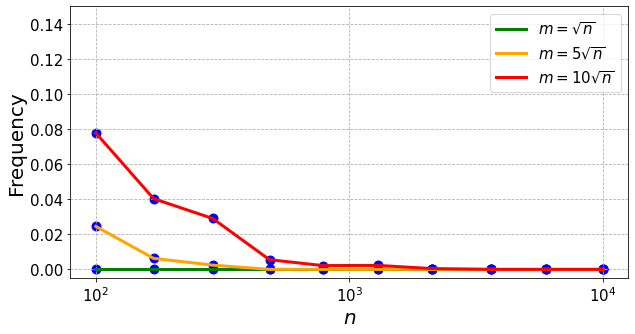

In [20]:
plt.figure(figsize=(10,5))

# for a, b1 in zip(m_set, crossing_rate):
#     if b1!=0:
#         plt.text(a, b1, format(b1,'.4f'), ha='center', va='bottom', rotation=20, fontsize=16)  
# # plt.legend()  #显示上面的label

plt.scatter(n_set,mean_crossing_rate[0,:], c="blue",s=80)
plt.plot(n_set,mean_crossing_rate[0,:], c="green",linewidth=3,label=r"$m=\sqrt{n}$")
plt.scatter(n_set,mean_crossing_rate[1,:], c="blue",s=80)
plt.plot(n_set,mean_crossing_rate[1,:], c="orange",linewidth=3,label=r"$m=5\sqrt{n}$")
plt.scatter(n_set,mean_crossing_rate[2,:], c="blue",s=80)
plt.plot(n_set,mean_crossing_rate[2,:], c="red",linewidth=3,label=r"$m=10\sqrt{n}$")
plt.xlim=(0,12000)
plt.ylim(-0.005,0.15)
#plt.title(r"Quantile crossing rate vs $m$",fontsize=20)
plt.xlabel(r"$n$",fontsize=20)
plt.ylabel("Frequency",fontsize=20)
plt.xscale("log",base=10)

plt.tick_params(axis="x", which="minor", length=0)
plt.tick_params(axis="x", which="major", labelsize=15)
plt.tick_params(axis="y", which="major", labelsize=15)
plt.legend(fontsize=15)

plt.grid(ls='--')
os.makedirs("./plot", exist_ok=True)
plt.savefig('./plot/mean_quantile_crossing_rate_ngrow_notitle.pdf',dpi=300)
plt.show()